### Understanding the Data

In [107]:
# Import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
# Read metadata csv file
df = pd.read_csv('data/HAM10000_metadata.csv', header=0)

# Replace white spaces with null values
df.replace(" ", np.nan, inplace=True)

# Show the first 5 rows of dataset
display(df.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [52]:
# Get the number of rows and columns
numRows, numColumns = df.shape
print("Number of rows:", numRows)
print("Number of columns:", numColumns)

Number of rows: 10015
Number of columns: 7


In [53]:
# Summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [54]:
# Statistic of dataset 
display(df.describe().round(3))

,age
count,9958.000
mean,51.864
std,16.969
min,0.000
25%,40.000
50%,50.000
75%,65.000
max,85.000


In [55]:
# Dictionary of lesion types
lesion_type_dict = {
    'akiec': 'Actinic Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis-Like Lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevi',
    'vasc': 'Vascular Lesions'
}

# Mapping short forms of lesion types to better descriptive names
df['cell_type'] = df['dx'].map(lesion_type_dict.get)

# Dictionary of confirmation methods
confirmation_method_dict = {
    'histo': 'Histopathology',
    'follow_up': 'Follow-up Examination',
    'consensus': 'Expert Consensus',
    'confocal': 'Confirmation by In-Vivo Confocal Microscopy'
}

# Mapping short forms of confirmation methods to better descriptive names
df['confirmation_method'] = df['dx_type'].map(confirmation_method_dict.get)

# Show the first 5 rows of dataset
display(df.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,confirmation_method
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis-Like Lesions,Histopathology


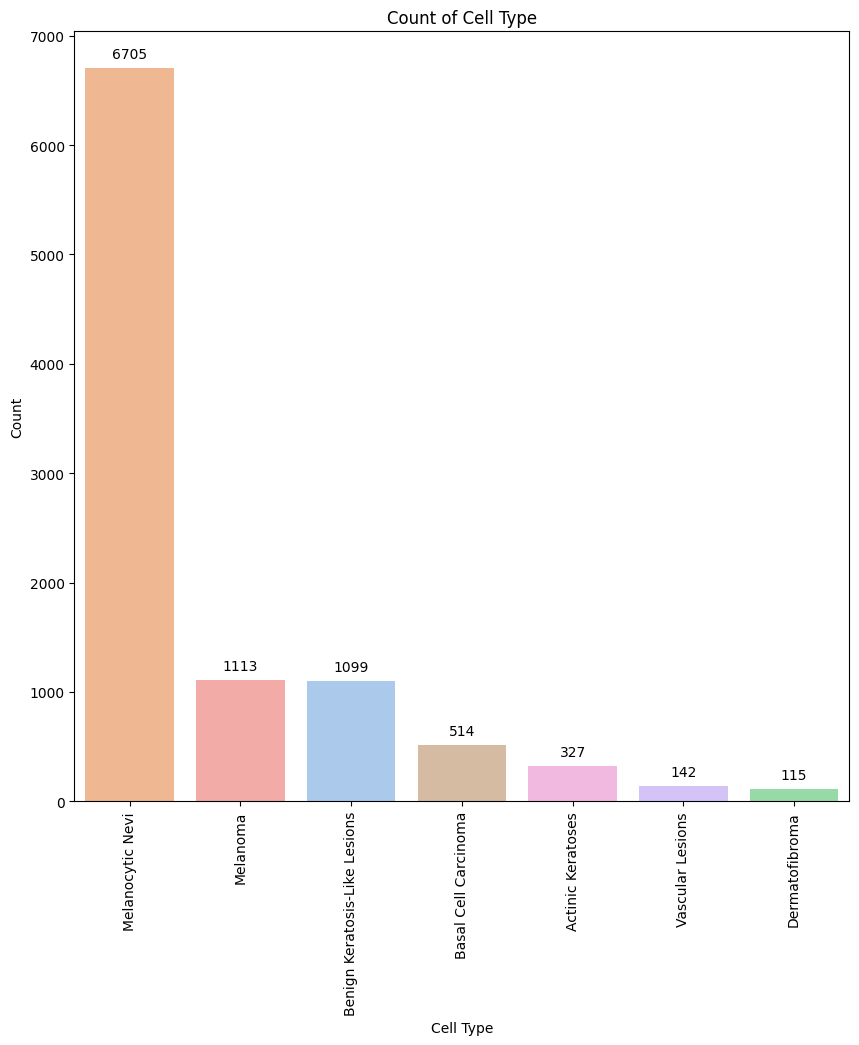

In [56]:
# Generate a count plot to visualize the distribution of cell type
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
sns.countplot(data=df, 
              x='cell_type', 
              hue='cell_type', 
              order=df['cell_type'].value_counts().index, 
              palette='pastel')
plt.title('Count of Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')

# Annotating count values on each bar
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
plt.show()

In [57]:
# Generate a pie chart to visualize the distribution of cell type
cell_type_pie_chart = px.pie(df, names='cell_type', title='Distribution of Cell Type')

# Identify the biggest part in the 'cell_type' column
biggest_part = df['cell_type'].value_counts().idxmax()

# Slice out the biggest part in the pie chart
cell_type_pie_chart.update_traces(
    marker=dict(colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']),
    pull=[0.1 if category == biggest_part else 0 for category in df['cell_type']],
    textinfo='percent+label',
    hoverinfo='label+percent'
    )

# Customize the layout of the chart
cell_type_pie_chart.update_layout(
    height=500, 
    width=700
    )

cell_type_pie_chart.show()

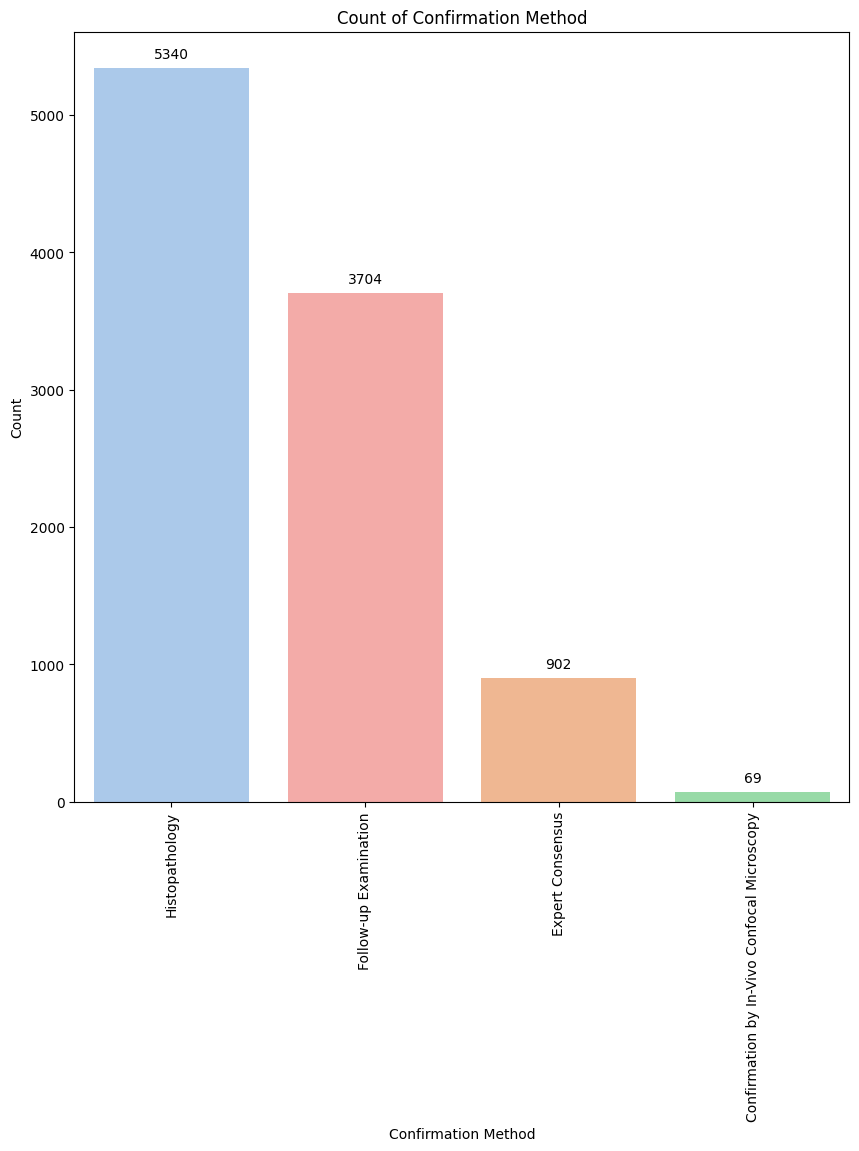

In [58]:
# Generate a count plot to visualize the distribution of confirmation method
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
sns.countplot(data=df, 
              x='confirmation_method', 
              hue='confirmation_method', 
              order=df['confirmation_method'].value_counts().index, 
              palette='pastel')
plt.title('Count of Confirmation Method')
plt.xlabel('Confirmation Method')
plt.ylabel('Count')

# Annotating count values on each bar
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

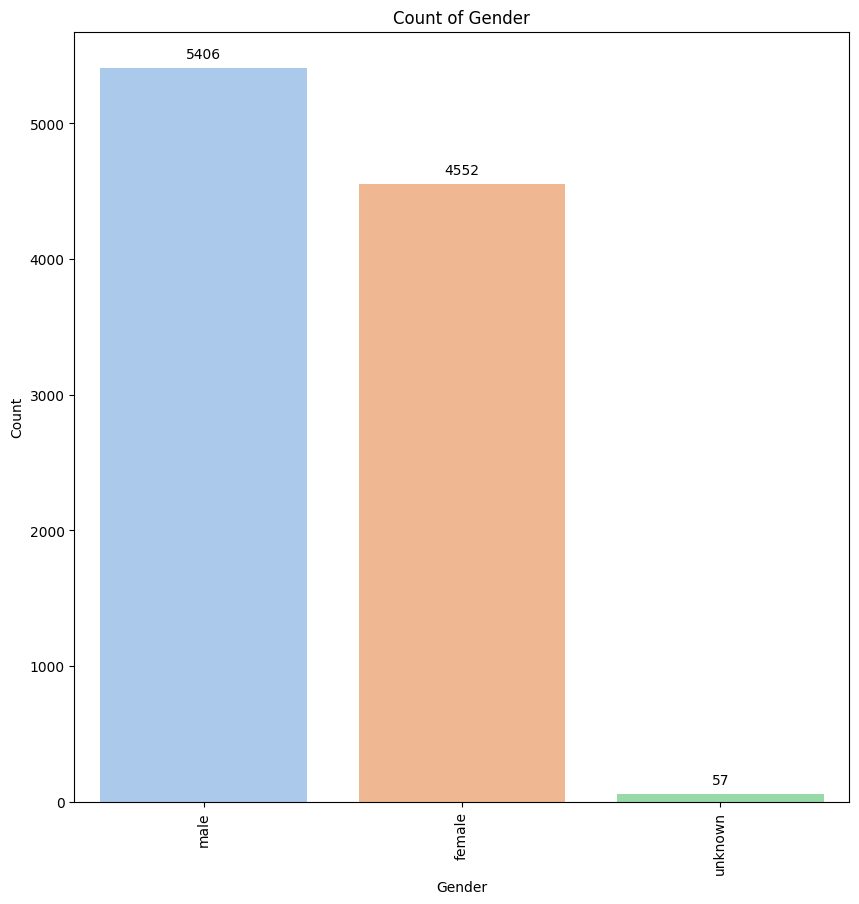

In [59]:
# Generate a count plot to visualize the distribution of gender
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
sns.countplot(data=df, 
              x='sex', 
              hue='sex', 
              order=df['sex'].value_counts().index, 
              palette='pastel')
plt.title('Count of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Annotating count values on each bar
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [60]:
# Generate a donut chart to visualize the distribution of gender
fig = px.pie(names=df['sex'].value_counts().index, values=df['sex'].value_counts().values,
             hole=0.5, labels={'names': 'Gender', 'values': 'Count'},
             title='Distribution of Gender')

# Identify the biggest part in the 'sex' column
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGray')),
                  pull=[0.1, 0], opacity=0.8)

fig.show()

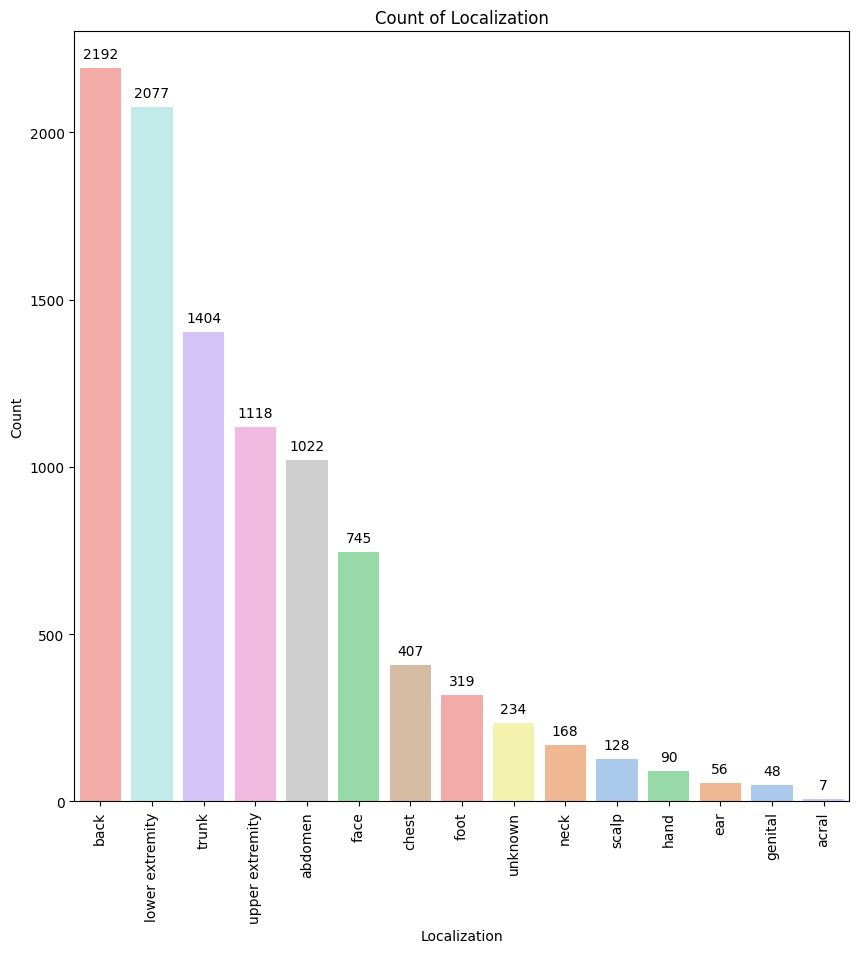

In [61]:
# Generate a count plot to visualize the distribution of localization
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
sns.countplot(data=df, 
              x='localization', 
              hue='localization', 
              order=df['localization'].value_counts().index, 
              palette='pastel')
plt.title('Count of Localization')
plt.xlabel('Localization')
plt.ylabel('Count')

# Annotating count values on each bar
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

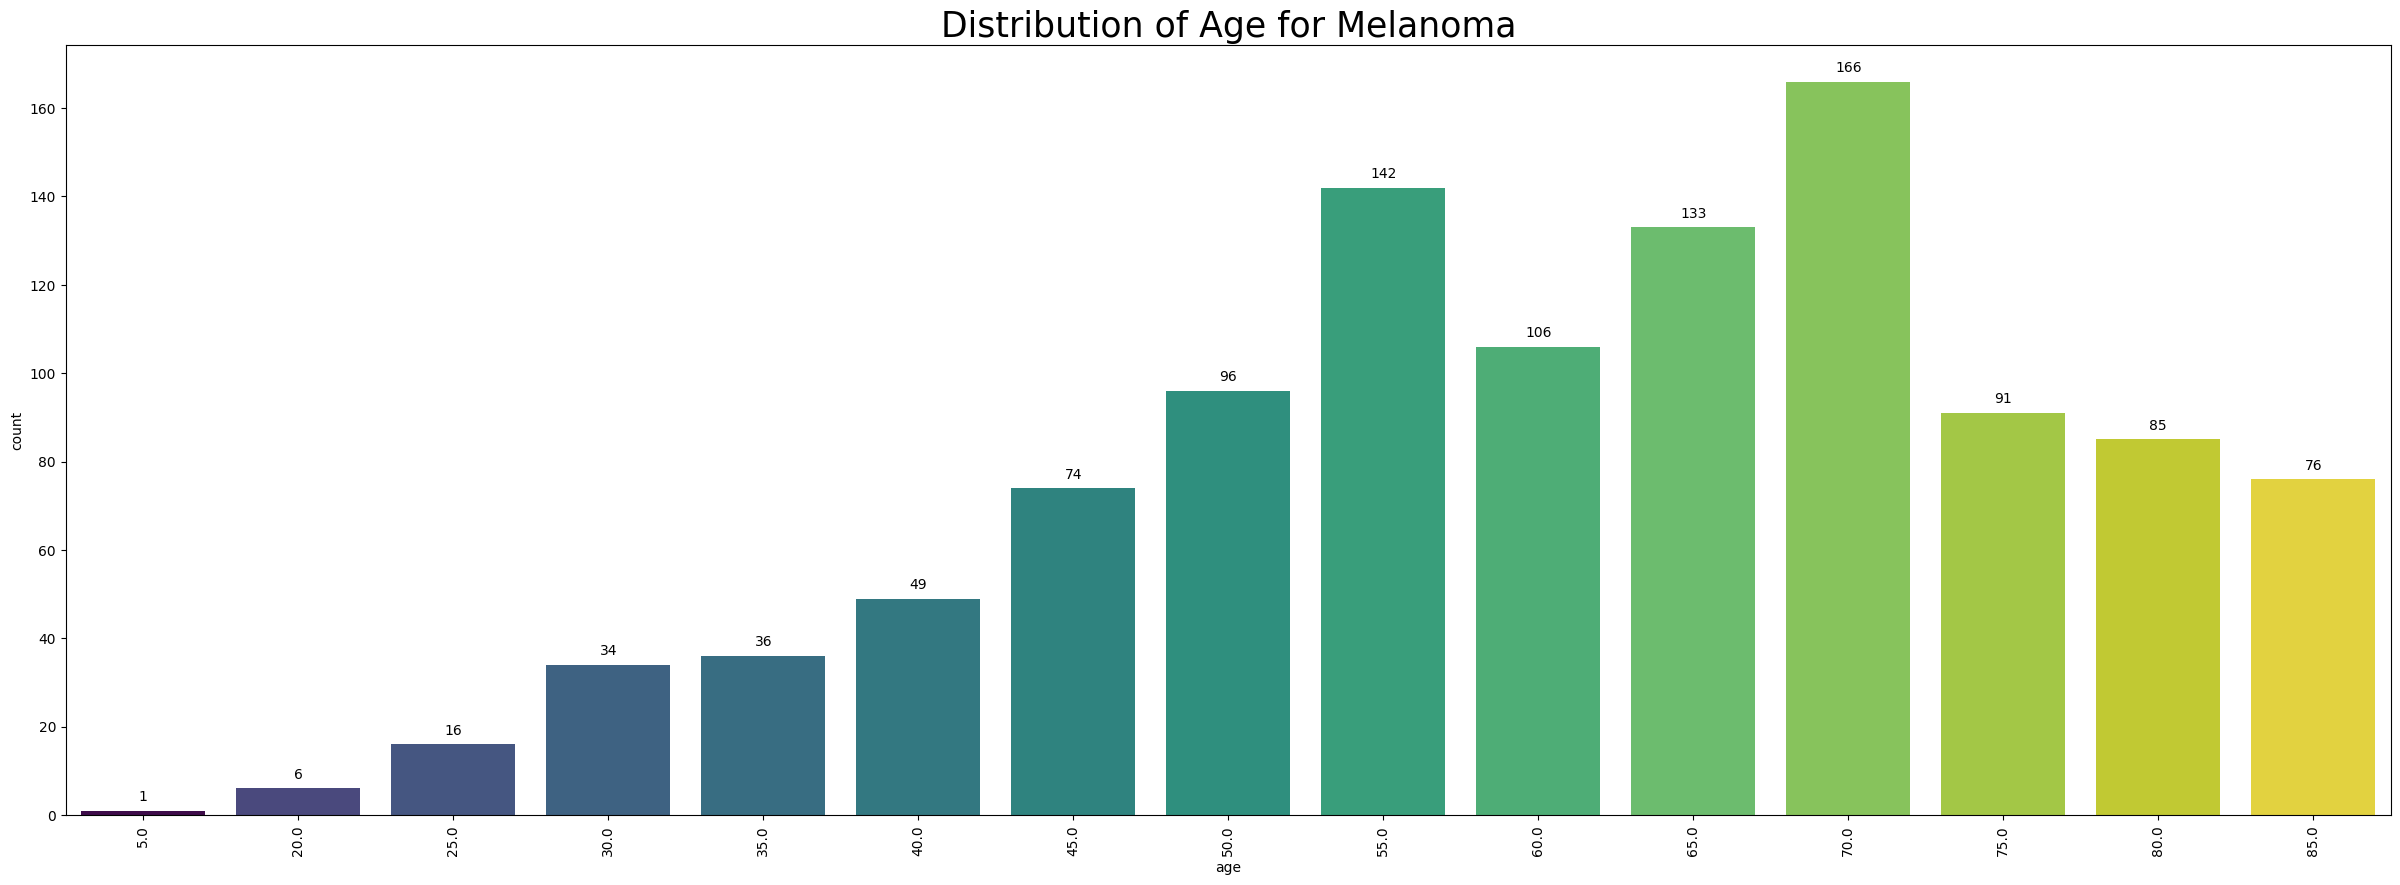

In [62]:
# Filter the DataFrame to include only 'Melanoma' cell type
melanoma_df = df[df['cell_type'] == 'Melanoma']

# Generate a count plot to visualize the distribution of age for 'Melanoma' cell types
plt.figure(figsize=(30, 10))
plt.xticks(rotation=90)
sns.countplot(data=melanoma_df, x='age', hue='age', palette='viridis', legend=False)
plt.title('Distribution of Age for Melanoma', fontsize=25)

# Annotating count values on each bar
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

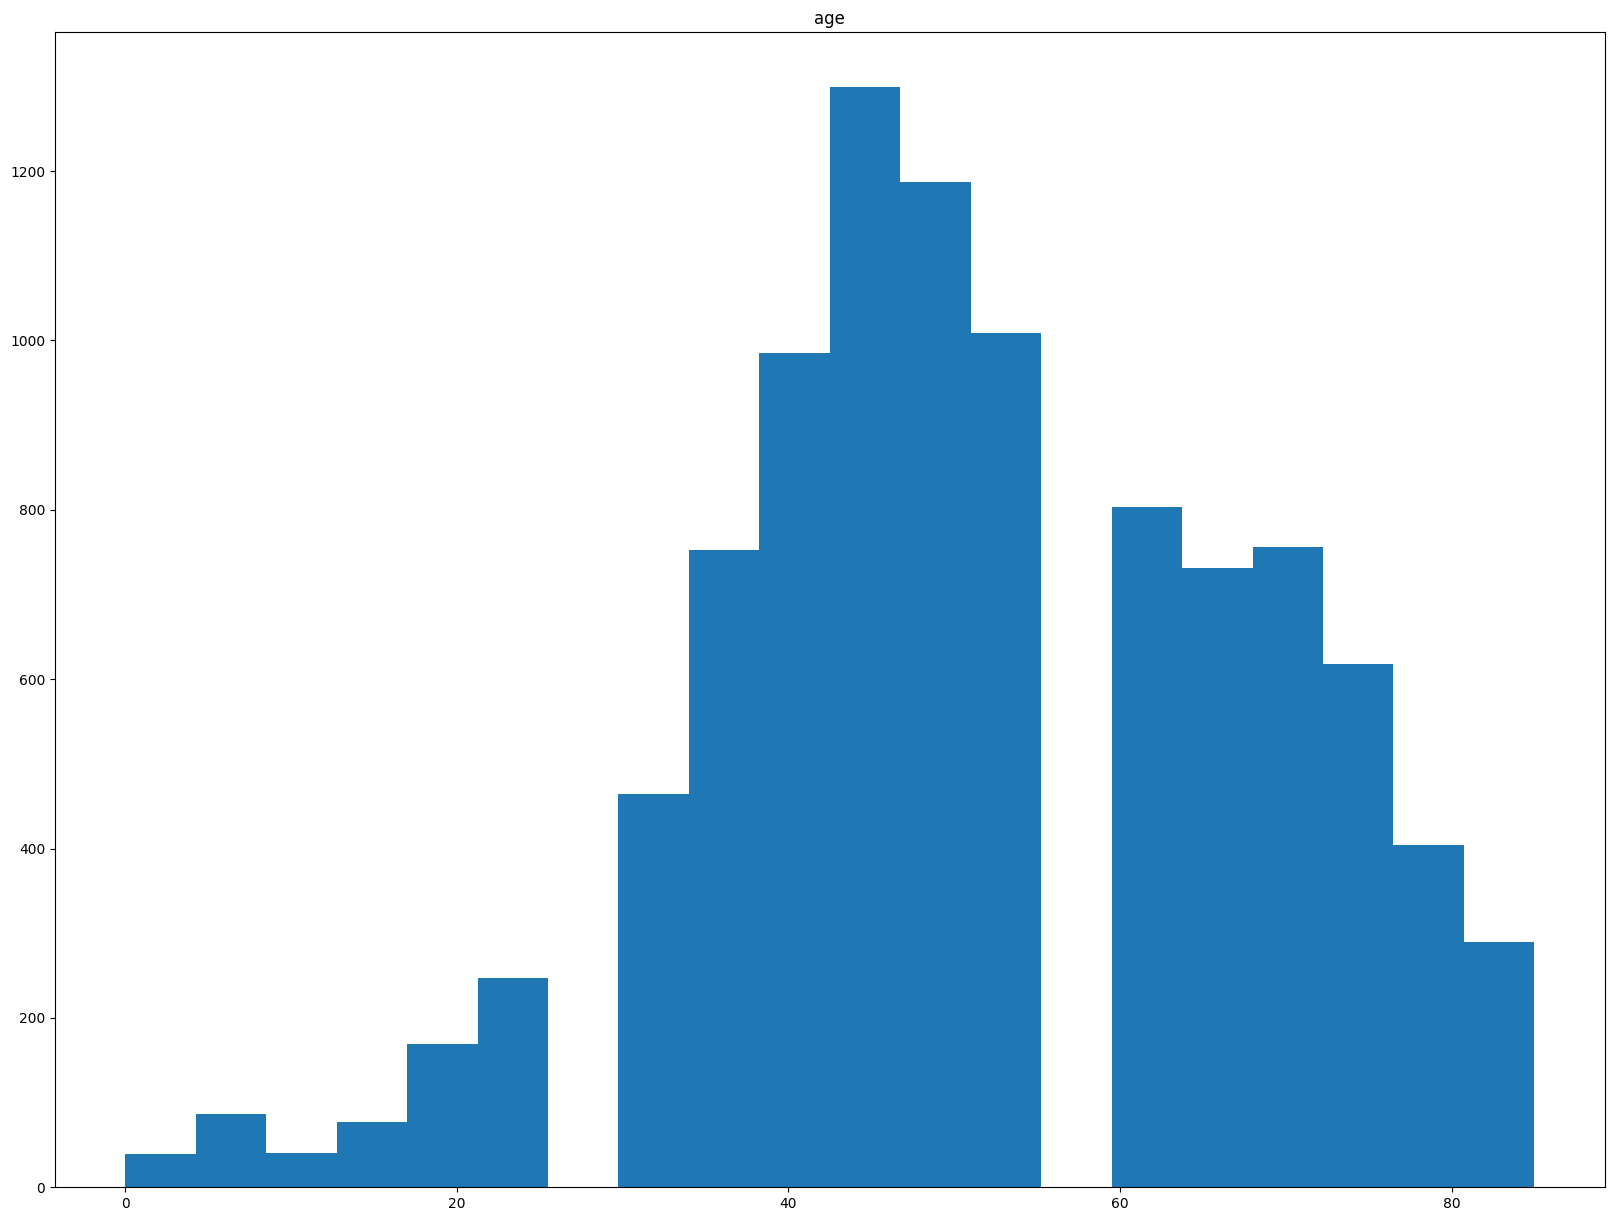

In [63]:
# Histogram
df.hist(figsize=(20, 15), bins=20, grid=False)
plt.show()

In [64]:
# Skewness
skew = df[['age']].skew().round(3)
print(skew)

age   -0.167
dtype: float64


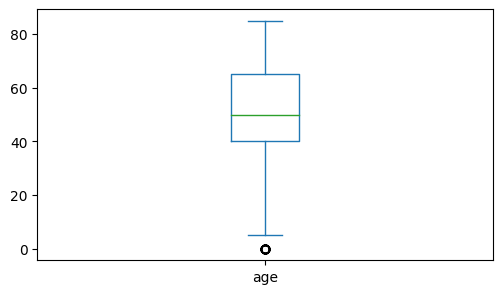

In [65]:
# Boxplot
df[['age']].plot(figsize=(20, 15), kind="box", subplots=True, layout=(4, 3), sharex=False, sharey=False)
plt.show()

### Data Preparation

In [66]:
# Get the number of duplicates in the dataset
print("Count of duplicates:")
print(df.duplicated().sum())

Count of duplicates:
0


In [67]:
# For each 'image_id', construct the full path by joining the directory and the filename with '.jpg' extension
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(r'C:\Users\Kris\Documents\Master of Applied Computing\ITS70404 - Principle of Data Science\Assignments\Assignment 3\HAM10000_images', f'{x}.jpg'))

# For each 'image_path', open the image, resize it to (32, 32)
df['image'] = df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((32, 32))))

# Show the first 2 rows of dataset
display(df.head(2))

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,confirmation_method,image_path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology,C:\Users\Kris\Documents\Master of Applied Comp...,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology,C:\Users\Kris\Documents\Master of Applied Comp...,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."


In [68]:
# Image size distribution
df['image'].map(lambda x: x.shape).value_counts()

image
(32, 32, 3)    10015
Name: count, dtype: int64

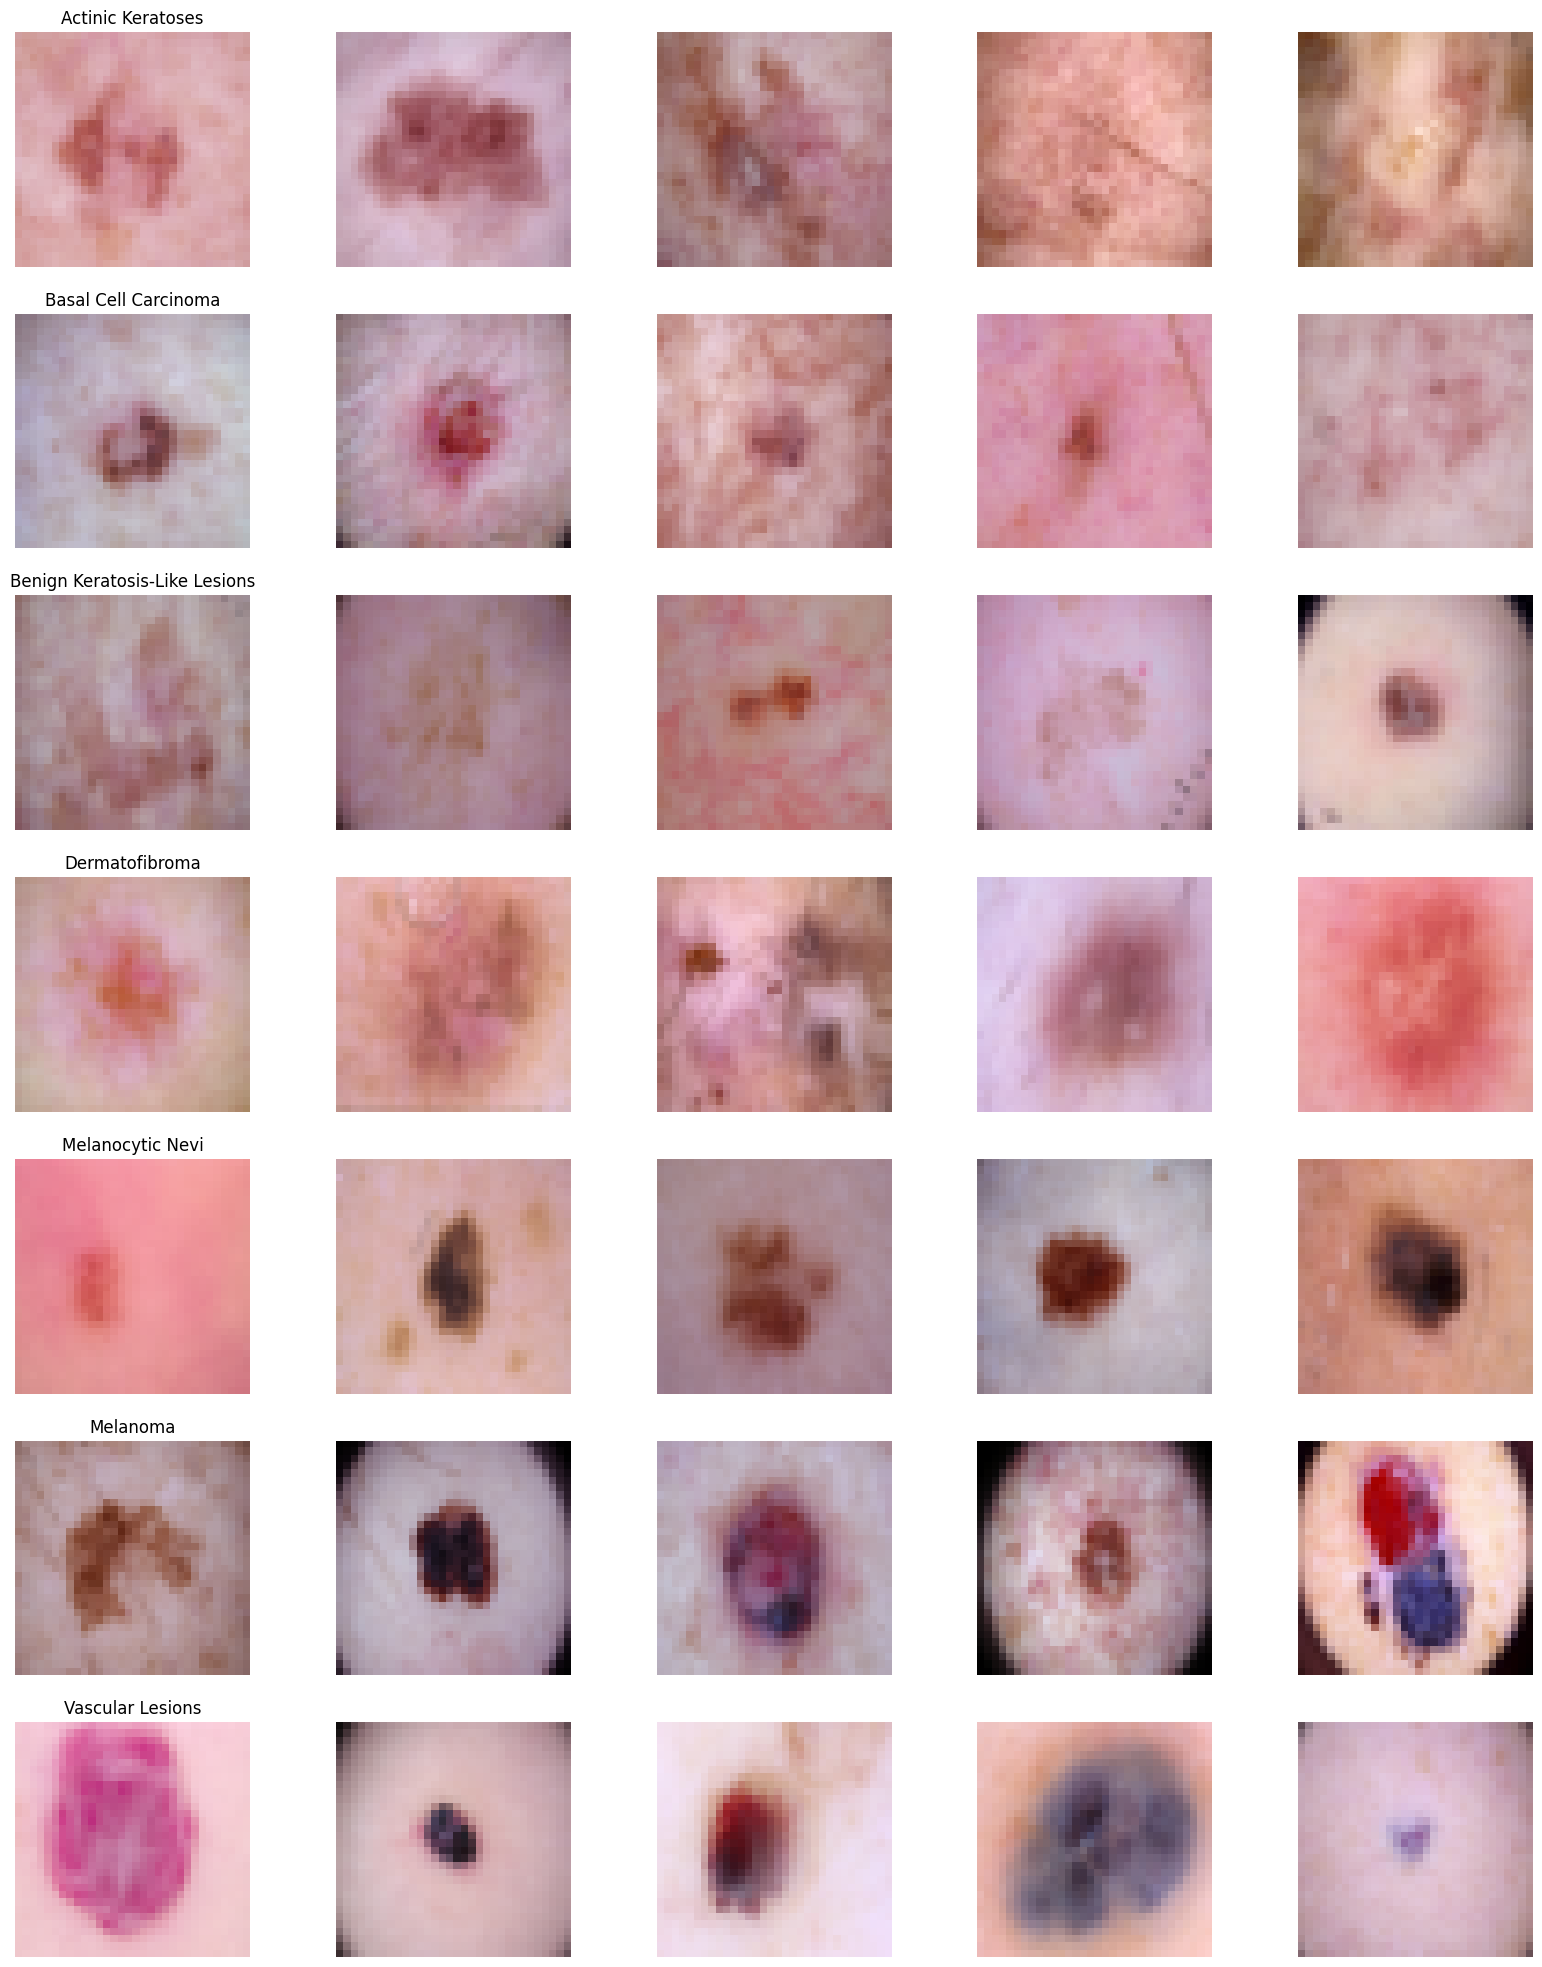

In [69]:
# Create a subplot grid with 7 rows and 5 columns for each row
fig, m_axs = plt.subplots(7, 5, figsize=(20, 25))

# Iterate over subplot rows, setting titles and displaying randomly sampled images for each cell type
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=100).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [70]:
# Create a new column 'melanoma' based on the condition in the 'cell_type' column for binary classification
df['melanoma'] = (df['cell_type'] == 'Melanoma').astype(int)

# Print the count of each value in the 'melanoma' column
print(df['melanoma'].value_counts())

# Show the first 2 rows of dataset
display(df.head(2))

melanoma
0    8902
1    1113
Name: count, dtype: int64


,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,confirmation_method,image_path,image,melanoma
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology,C:\Users\Kris\Documents\Master of Applied Comp...,"[[[191, 152, 192], [194, 154, 193], [196, 152,...",0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology,C:\Users\Kris\Documents\Master of Applied Comp...,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ...",0


In [71]:
# Drop the unused columns from the dataset
df.drop(columns=['lesion_id', 'image_id', 'dx', 'dx_type'], inplace=True)

# Show the first 2 rows of dataset
display(df.head(2))

,age,sex,localization,cell_type,confirmation_method,image_path,image,melanoma
0,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology,C:\Users\Kris\Documents\Master of Applied Comp...,"[[[191, 152, 192], [194, 154, 193], [196, 152,...",0
1,80.0,male,scalp,Benign Keratosis-Like Lesions,Histopathology,C:\Users\Kris\Documents\Master of Applied Comp...,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ...",0


In [72]:
# Remove the row where the age is labeled as 0 in the 'age' column
df = df[~(df['age'] == 0)]

# Update the new shape of the dataset
numRows, numColumns = df.shape

# Print the unique values in the "gender" column
print("The minimum value of 'age':", df['age'].min())

The minimum value of 'age': 5.0


In [73]:
# Remove the row where the sex is labeled as 'unknown'
df = df[~(df['sex'] == "unknown")]

# Update the new shape of the dataset
numRows, numColumns = df.shape

# Print the unique values in the 'sex' column
print("The unique values of 'sex':", df['sex'].unique())

The unique values of 'sex': ['male' 'female']


In [74]:
# Remove the row where the localization is labeled as 'unknown'
df = df[~(df['localization'] == "unknown")]

# Update the new shape of the dataset
numRows, numColumns = df.shape

# Print the unique values in the 'localization' column
print("The unique values of 'localization':", df['localization'].unique())

The unique values of 'localization': ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


In [75]:
# Get the number of missing values from each colunn
print("Count of missing values:")
print(df.isna().sum())

Count of missing values:
age                    10
sex                     0
localization            0
cell_type               0
confirmation_method     0
image_path              0
image                   0
melanoma                0
dtype: int64


In [76]:
# Impute 'age' column with its mean value
df['age'].fillna(df['age'].mean(), inplace=True)

# Print the number of missing values after imputation from each colunn
print("Impute missing data:")
print(df.isna().sum())

Impute missing data:
age                    0
sex                    0
localization           0
cell_type              0
confirmation_method    0
image_path             0
image                  0
melanoma               0
dtype: int64


In [77]:
# Statistic of dataset after mean imputation
display(df.describe().round(3))

,age,melanoma
count,9734.000,9734.000
mean,52.197,0.113
std,16.681,0.317
min,5.000,0.000
25%,40.000,0.000
50%,50.000,0.000
75%,65.000,0.000
max,85.000,1.000


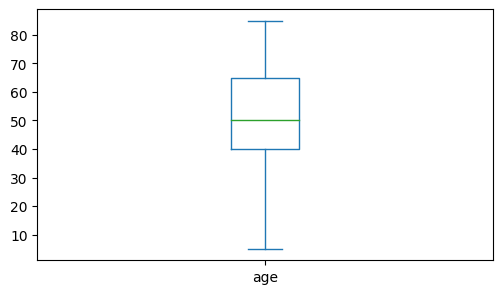

In [78]:
# Boxplot
df[['age']].plot(figsize=(20, 15), kind="box", subplots=True, layout=(4, 3), sharex=False, sharey=False)
plt.show()

In [80]:
# Separating the dataset into two subsets based on the 'melanoma' class
df_not_melanoma = df[df['melanoma'] == 0]
df_melanoma = df[df['melanoma'] == 1]

# Resample each class to achieve a balanced dataset with 2000 samples
df_not_melanoma = resample(df_not_melanoma, replace=True, n_samples=2000, random_state=42) 
df_melanoma = resample(df_melanoma, replace=True, n_samples=2000, random_state=42)

# Combine the resampled datasets
df_balanced = pd.concat([df_not_melanoma, df_melanoma])

# Shuffle rows before splitting data into features (X) and outcome (Y)
df_balanced = shuffle(df_balanced, random_state=42)

# Get unique values count for 'melanoma' column
print(df_balanced['melanoma'].value_counts())

melanoma
0    2000
1    2000
Name: count, dtype: int64


### Machine Learning: Decision Tree, Random Forest, SVM, kNN

In [81]:
# Flatten the pixel values for each image
df_balanced['flattened_image'] = df_balanced['image'].apply(lambda x: np.array(x).flatten())

# Create a copy of dataset with flattened images and melanoma classification for Decision Tree, Random Forest, SVM, and kNN
df_flattened = df_balanced[['flattened_image', 'melanoma']].copy()

# Split the dataset into features (X) and target variable (y)
X_flattened = np.array(df_flattened['flattened_image'].tolist())
y_flattened = np.array(df_flattened['melanoma'])

# Split the data into training and testing sets
X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(X_flattened, 
                                                                        y_flattened, 
                                                                        test_size=0.2, 
                                                                        random_state=42)

# Scale pixel values
X_train_flat= np.array(X_train_flat.tolist()) / 255
X_test_flat = np.array(X_test_flat.tolist()) / 255

# Print the shapes of the training and testing sets
print("Training set - x:", X_train_flat.shape)
print("Training set - y:", X_test_flat.shape)
print("Testing set - x: ", y_train_flat.shape)
print("Testing set - y: ", y_test_flat.shape)

Training set - x: (3200, 3072)
Training set - y: (800, 3072)
Testing set - x:  (3200,)
Testing set - y:  (800,)


Decision Tree Accuracy: 0.842
Decision Tree Precision: 0.832
Decision Tree Recall: 0.861
Decision Tree AUC-ROC Score: 0.842


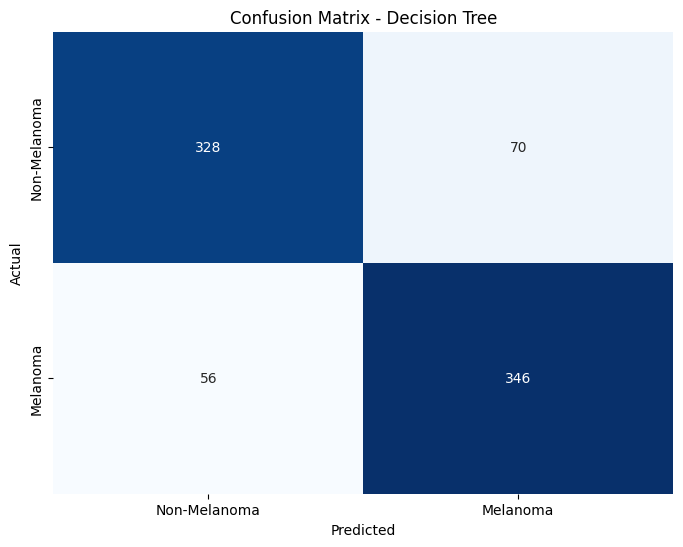

In [82]:
# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_flat, y_train_flat)
dt_predictions = dt_classifier.predict(X_test_flat)

# Accuracy of Decision Tree
dt_accuracy = accuracy_score(y_test_flat, dt_predictions)
print(f"Decision Tree Accuracy: {round(dt_accuracy, 3)}")

# Precision of Decision Tree
dt_precision = precision_score(y_test_flat, dt_predictions)
print(f"Decision Tree Precision: {round(dt_precision, 3)}")

# Recall of Decision Tree
dt_recall = recall_score(y_test_flat, dt_predictions)
print(f"Decision Tree Recall: {round(dt_recall, 3)}")

# AUC-ROC Curve of Decision Tree
dt_probabilities = dt_classifier.predict_proba(X_test_flat)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test_flat, dt_probabilities)
dt_auc = auc(dt_fpr, dt_tpr)
print(f"Decision Tree AUC-ROC Score: {round(dt_auc, 3)}")

# Confusion Matrix
dt_cm = confusion_matrix(y_test_flat, dt_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Melanoma', 'Melanoma'],
            yticklabels=['Non-Melanoma', 'Melanoma'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Random Forest Accuracy: 0.872
Random Forest Precision: 0.861
Random Forest Recall: 0.891
Random Forest AUC-ROC Score: 0.961


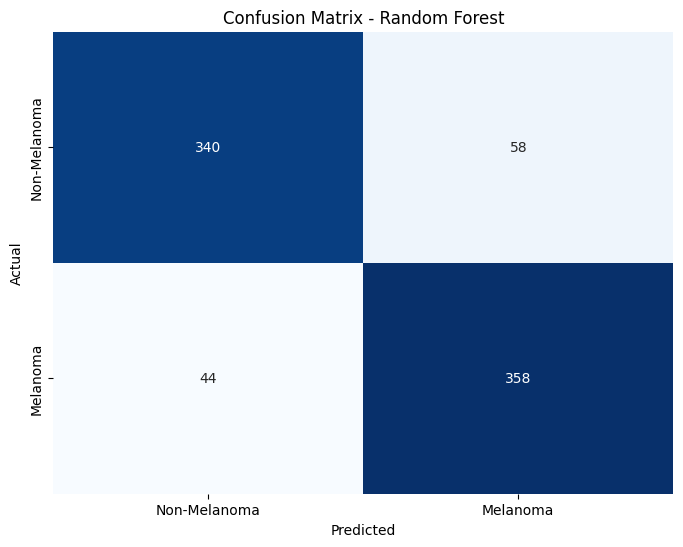

In [83]:
# Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_flat, y_train_flat)
rf_predictions = rf_classifier.predict(X_test_flat)

# Accuracy of Random Forest
rf_accuracy = accuracy_score(y_test_flat, rf_predictions)
print(f"Random Forest Accuracy: {round(rf_accuracy, 3)}")

# Precision of Random Forest
rf_precision = precision_score(y_test_flat, rf_predictions)
print(f"Random Forest Precision: {round(rf_precision, 3)}")

# Recall of Random Forest
rf_recall = recall_score(y_test_flat, rf_predictions)
print(f"Random Forest Recall: {round(rf_recall, 3)}")

# AUC-ROC Curve of Random Forest
rf_probabilities = rf_classifier.predict_proba(X_test_flat)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test_flat, rf_probabilities)
rf_auc = auc(rf_fpr, rf_tpr)
print(f"Random Forest AUC-ROC Score: {round(rf_auc, 3)}")

# Confusion Matrix
rf_cm = confusion_matrix(y_test_flat, rf_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Melanoma', 'Melanoma'],
            yticklabels=['Non-Melanoma', 'Melanoma'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM (Linear Kernel) Accuracy: 0.806
SVM (Linear Kernel) Precision: 0.791
SVM (Linear Kernel) Recall: 0.836
SVM (Linear Kernel) AUC-ROC Score: 0.862


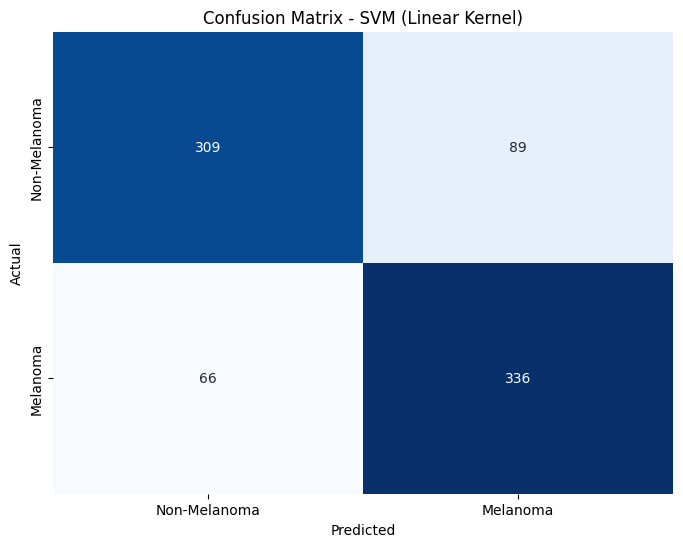

In [84]:
# SVM with Linear Kernel
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train_flat, y_train_flat)
svm_predictions = svm_classifier.predict(X_test_flat)

# Accuracy of SVM with Linear Kernel
svm_accuracy = accuracy_score(y_test_flat, svm_predictions)
print(f"SVM (Linear Kernel) Accuracy: {round(svm_accuracy, 3)}")

# Precision of SVM with Linear Kernel
svm_precision = precision_score(y_test_flat, svm_predictions)
print(f"SVM (Linear Kernel) Precision: {round(svm_precision, 3)}")

# Recall of SVM with Linear Kernel
svm_recall = recall_score(y_test_flat, svm_predictions)
print(f"SVM (Linear Kernel) Recall: {round(svm_recall, 3)}")

# AUC-ROC Curve of SVM with Linear Kernel
svm_probabilities = svm_classifier.predict_proba(X_test_flat)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test_flat, svm_probabilities)
svm_auc = auc(svm_fpr, svm_tpr)
print(f"SVM (Linear Kernel) AUC-ROC Score: {round(svm_auc, 3)}")

# Confusion Matrix
svm_cm = confusion_matrix(y_test_flat, svm_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Melanoma', 'Melanoma'],
            yticklabels=['Non-Melanoma', 'Melanoma'])
plt.title('Confusion Matrix - SVM (Linear Kernel)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

KNN Accuracy: 0.751
KNN Precision: 0.78
KNN Recall: 0.704
KNN AUC-ROC Score: 0.849


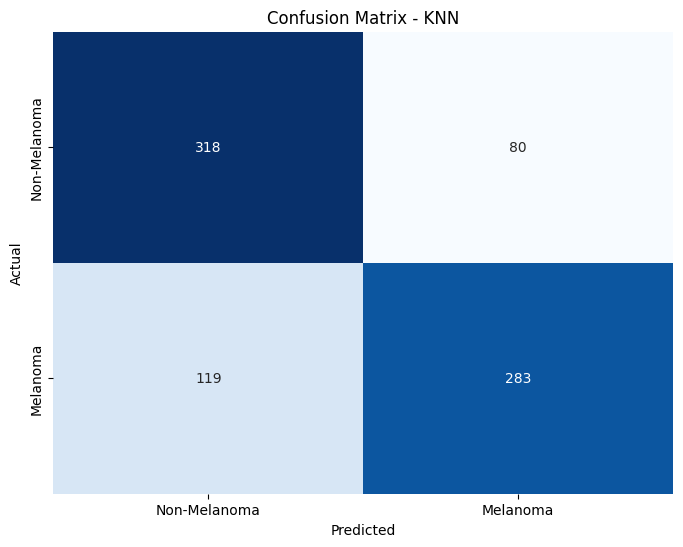

In [85]:
# k-Nearest Neighbours (KNN)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_flat, y_train_flat)
knn_predictions = knn_classifier.predict(X_test_flat)

# Accuracy of k-Nearest Neighbours (KNN)
knn_accuracy = accuracy_score(y_test_flat, knn_predictions)
print(f"KNN Accuracy: {round(knn_accuracy, 3)}")

# Precision of k-Nearest Neighbours (KNN)
knn_precision = precision_score(y_test_flat, knn_predictions)
print(f"KNN Precision: {round(knn_precision, 3)}")

# Recall of k-Nearest Neighbours (KNN)
knn_recall = recall_score(y_test_flat, knn_predictions)
print(f"KNN Recall: {round(knn_recall, 3)}")

# AUC-ROC Curve of k-Nearest Neighbours (KNN)
knn_probabilities = knn_classifier.predict_proba(X_test_flat)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test_flat, knn_probabilities)
knn_auc = auc(knn_fpr, knn_tpr)
print(f"KNN AUC-ROC Score: {round(knn_auc, 3)}")

# Confusion Matrix
knn_cm = confusion_matrix(y_test_flat, knn_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Melanoma', 'Melanoma'],
            yticklabels=['Non-Melanoma', 'Melanoma'])
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Machine Learning: CNN

In [108]:
# Create a copy of dataset with unflattened images and melanoma classification for CNN
df_cnn = df_balanced[['image', 'melanoma']].copy()

# Split the dataset into training and testing sets
X_cnn = np.array(df_cnn['image'].tolist())
y_cnn = np.array(df_cnn['melanoma'])

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, 
                                                                    y_cnn, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

# Scale pixel values
X_train_cnn = np.array(X_train_cnn.tolist()) / 255
X_test_cnn = np.array(X_test_cnn.tolist()) / 255

# Display the shapes of the training and testing sets
print("Training set - x:", X_train_cnn.shape)
print("Training set - y:", X_test_cnn.shape)
print("Testing set - x: ", y_train_cnn.shape)
print("Testing set - y: ", y_test_cnn.shape)

Training set - x: (3200, 32, 32, 3)
Training set - y: (800, 32, 32, 3)
Testing set - x:  (3200,)
Testing set - y:  (800,)


In [109]:
# CNN Model
model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Summary of Model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 15, 15, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 6, 6, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 64)          73792     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 2, 2, 64)         

In [148]:
# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                              patience=3,
                              verbose=1,
                              factor=0.5,
                              min_lr=0.00001)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/50
200/200 [==============================] - 6s 26ms/step - loss: 0.1559 - accuracy: 0.9378 - val_loss: 0.5333 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/50
200/200 [==============================] - 5s 25ms/step - loss: 0.1546 - accuracy: 0.9366 - val_loss: 0.5197 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 3/50
200/200 [==============================] - 5s 25ms/step - loss: 0.1467 - accuracy: 0.9400 - val_loss: 0.4332 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 4/50
200/200 [==============================] - 5s 25ms/step - loss: 0.1742 - accuracy: 0.9319 - val_loss: 0.6510 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 5/50
200/200 [==============================] - 5s 25ms/step - loss: 0.1832 - accuracy: 0.9325 - val_loss: 0.4759 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 6/50
198/200 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9391
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 [==============================] - 5s 25

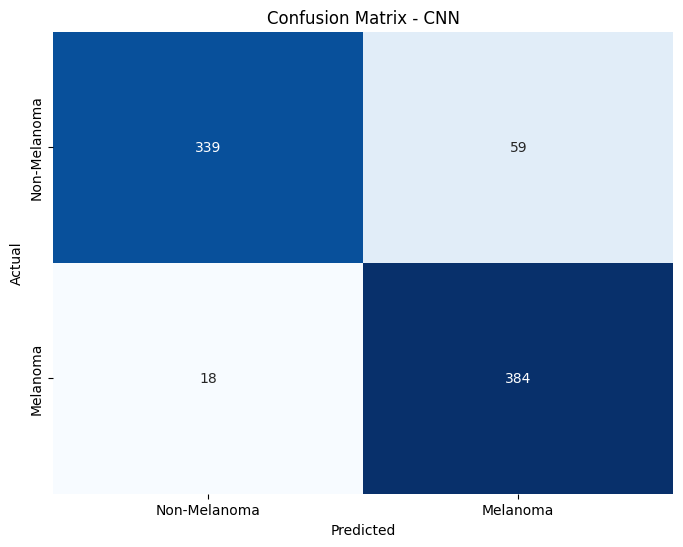

In [144]:
# Train the model with augmented data
history = model.fit(datagen.flow(X_train_cnn, y_train_cnn, batch_size=16),
                    steps_per_epoch=len(X_train_cnn) // 16,
                    epochs=50,
                    validation_data=(X_test_cnn, y_test_cnn),
                    validation_steps=len(X_test_cnn) // 16,
                    callbacks=[reduce_lr])

# Evaluate the model
cnn_predictions = model.predict(X_test_cnn)
cnn_predictions = (cnn_predictions > 0.5).astype(int)

# Accuracy of CNN
cnn_accuracy = accuracy_score(y_test_flat, cnn_predictions)
print(f"CNN Accuracy: {round(cnn_accuracy, 3)}")

# Precision of CNN
cnn_precision = precision_score(y_test_flat, cnn_predictions)
print(f"CNN Precision: {round(cnn_precision, 3)}")

# Recall of CNN
cnn_recall = recall_score(y_test_flat, cnn_predictions)
print(f"CNN Recall: {round(cnn_recall, 3)}")

# AUC-ROC Curve of CNN
cnn_probabilities = model.predict(X_test_cnn)
cnn_fpr, cnn_tpr, _ = roc_curve(y_test_cnn, cnn_probabilities)
cnn_auc = auc(cnn_fpr, cnn_tpr)
print(f"\nCNN AUC-ROC Score: {round(cnn_auc, 3)}")

# Confusion Matrix
cnn_cm = confusion_matrix(y_test_flat, cnn_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Melanoma', 'Melanoma'],
            yticklabels=['Non-Melanoma', 'Melanoma'])
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

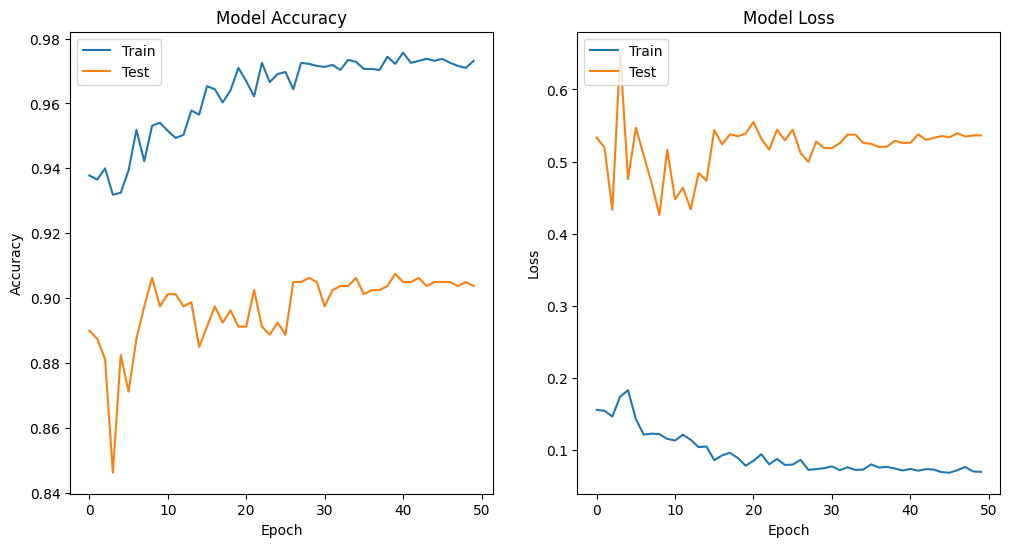

In [146]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

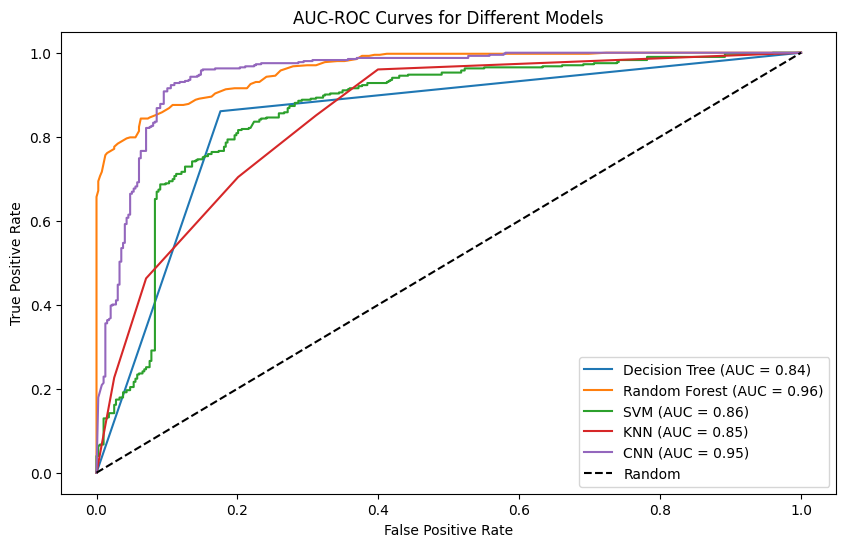

In [147]:
# Plot AUC-ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})')
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {cnn_auc:.2f})')
plt.title('AUC-ROC Curves for Different Models')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()